# Imports

In [1]:
import pandas as pd
import numpy as np
import os
import gc
import sys 

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)

from utils import clean_database, perform_voting_feature_selection, perform_transformation_feature_selection, perform_voting_feature_transformation, compare_feature_transformation_methods
pd.set_option('display.max_columns', None)

preprocessing_dir = os.path.join('figures','preprocessing', 'RF2')
db_path = os.path.join('..', 'data', 'datasets', '5G NIDD', 'Combined.csv')

# Data cleaning and splitting

[Preprocessing] Dropping artifact columns: ['Unnamed: 0']
Original shape: (1215890, 51)
Shape after removing duplicates: (1215869, 51)

[Dataset Info] Attack Type Distribution (Counts):
Attack Type
Benign            477716
UDPFlood          457340
HTTPFlood         140812
SlowrateDoS        73124
TCPConnectScan     20052
SYNScan            20043
UDPScan            15906
SYNFlood            9721
ICMPFlood           1155
Name: count, dtype: int64
[Preprocessing] Final feature set (40): ['Dur', 'Mean', 'Sum', 'Min', 'Max', 'Proto', 'sTos', 'dTos', 'sDSb', 'dDSb', 'sTtl', 'dTtl', 'Cause', 'TotPkts', 'SrcPkts', 'DstPkts', 'TotBytes', 'SrcBytes', 'DstBytes', 'Offset', 'sMeanPktSz', 'dMeanPktSz', 'Load', 'SrcLoad', 'DstLoad', 'Loss', 'SrcLoss', 'DstLoss', 'pLoss', 'SrcGap', 'DstGap', 'Rate', 'SrcRate', 'DstRate', 'State', 'SrcWin', 'DstWin', 'TcpRtt', 'SynAck', 'AckDat']

[Verification] Class distribution (normalized) across splits:
                Original     Train       Val      Test
Attac

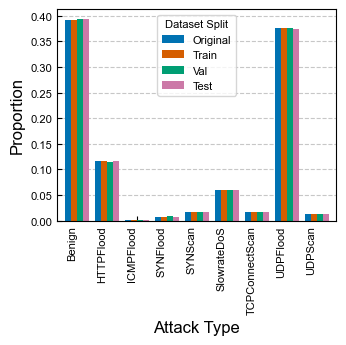

[Preprocessing] Applying standard scaling...
<class 'pandas.core.frame.DataFrame'>
Index: 972695 entries, 285273 to 583254
Data columns (total 40 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Dur         972695 non-null  float32
 1   Mean        972695 non-null  float32
 2   Sum         972695 non-null  float32
 3   Min         972695 non-null  float32
 4   Max         972695 non-null  float32
 5   Proto       972695 non-null  float32
 6   sTos        972695 non-null  float32
 7   dTos        972695 non-null  float32
 8   sDSb        972695 non-null  float32
 9   dDSb        972695 non-null  float32
 10  sTtl        972695 non-null  float32
 11  dTtl        972695 non-null  float32
 12  Cause       972695 non-null  float32
 13  TotPkts     972695 non-null  float32
 14  SrcPkts     972695 non-null  float32
 15  DstPkts     972695 non-null  float32
 16  TotBytes    972695 non-null  float32
 17  SrcBytes    972695 non-null  float32
 18 

5687

In [2]:
X_train, X_val, X_test, y_train, y_val, y_test, output_encoder = clean_database(db_path, preprocessing_dir, do_scale=True, fix_skewness=False)
gc.collect()


In [3]:
# Print the number of remaining features
print(f"Remaining features count: {X_train.shape[1]}")

# Print the list of remaining feature names
print("Remaining features list:")
print(X_train.columns.tolist())

Remaining features count: 40
Remaining features list:
['Dur', 'Mean', 'Sum', 'Min', 'Max', 'Proto', 'sTos', 'dTos', 'sDSb', 'dDSb', 'sTtl', 'dTtl', 'Cause', 'TotPkts', 'SrcPkts', 'DstPkts', 'TotBytes', 'SrcBytes', 'DstBytes', 'Offset', 'sMeanPktSz', 'dMeanPktSz', 'Load', 'SrcLoad', 'DstLoad', 'Loss', 'SrcLoss', 'DstLoss', 'pLoss', 'SrcGap', 'DstGap', 'Rate', 'SrcRate', 'DstRate', 'State', 'SrcWin', 'DstWin', 'TcpRtt', 'SynAck', 'AckDat']


# Arguments

In [4]:
n_features_list = [35, 30, 25, 20, 15, 10, 5, 1]

# Feature selection methods loop

In [5]:
# Helper to save DataFrame or Numpy array to CSV
def save_to_csv(data, full_path):
    if isinstance(data, pd.DataFrame):
        data.to_csv(full_path, index=False)
    else:
        # Convert numpy array to DataFrame
        pd.DataFrame(data).to_csv(full_path, index=False)
        
# 1. Loop through each configuration
for n in n_features_list:
    print(f"\n{'='*80}")
    print(f"STARTING PIPELINE: {n} FEATURES")
    print(f"{'='*80}")
    
    # --- A. Setup Version and Directory ---
    version = f"{n}F"
    save_dir = os.path.join('..', 'data frames', 'main', 'RF2', f'{n} features')
    
    # Create the directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        print(f"[Setup] Created directory: {save_dir}")
    else:
        print(f"[Setup] Directory exists: {save_dir}")

    # --- B. Perform Feature Selection ---
    # We pass the ORIGINAL full datasets (X_train, etc.)
    print(f"[Step 1] Running Voting Feature Selection...")
    selected_features, comparison_results = perform_voting_feature_selection(
        X_train, y_train, X_val, y_val, 
        n_features=n, 
        sample_size=None, 
        file_path=preprocessing_dir, # Keeps selection plots in the main preprocessing folder
        version=version
    )
    
    # Save the list of selected features to a text file
    with open(os.path.join(save_dir, f'selected_features_{version}.txt'), 'w') as f:
        f.write('\n'.join(selected_features))

    # --- C. Subset the Data ---
    # CRITICAL: We create COPIES (sub) instead of overwriting X_train.
    # This preserves the original X_train for the next iteration of the loop.
    print(f"[Step 2] Dropping non-selected features...")
    X_train_sub = X_train[selected_features].copy()
    X_val_sub = X_val[selected_features].copy()
    X_test_sub = X_test[selected_features].copy()

    # --- D. Save the Dataframes (Skipping Preprocessing/Sampling) ---
    print(f"[Step 3] Saving dataframes to {save_dir} (Skipping Sampling)...")
    
    save_to_csv(X_train_sub, os.path.join(save_dir, f'X_train_{version}.csv'))
    save_to_csv(X_val_sub, os.path.join(save_dir, f'X_val_{version}.csv'))
    save_to_csv(X_test_sub, os.path.join(save_dir, f'X_test_{version}.csv'))
    save_to_csv(y_train, os.path.join(save_dir, f'y_train_{version}.csv'))
    save_to_csv(y_val, os.path.join(save_dir, f'y_val_{version}.csv'))
    save_to_csv(y_test, os.path.join(save_dir, f'y_test_{version}.csv'))

    # --- F. Save Label Classes ---
    # Saving the classes is crucial for decoding predictions later
    np.save(os.path.join(save_dir, f'label_classes_{version}.npy'), output_encoder.classes_)
    
    print(f"COMPLETED: {n} features pipeline finished.\n")



STARTING PIPELINE: 35 FEATURES
[Setup] Created directory: ../data frames/main/RF2/35 features
[Step 1] Running Voting Feature Selection...

[Comparison] Using full training data (972695 samples) for feature selection.

Comparing Feature Selection Methods

--- Filter Method: pearson ---

[Filter] Starting PEARSON Feature Selection to select top 35 features...
[Filter] Completed in 0.08 seconds.
[Filter] Selected Features: ['Dur', 'Mean', 'Sum', 'Min', 'Max', 'Proto', 'sTos', 'dTos', 'sDSb', 'dDSb', 'sTtl', 'dTtl', 'Cause', 'TotPkts', 'SrcPkts', 'DstPkts', 'TotBytes', 'SrcBytes', 'DstBytes', 'Offset', 'sMeanPktSz', 'dMeanPktSz', 'SrcLoad', 'Loss', 'SrcLoss', 'DstLoss', 'pLoss', 'Rate', 'SrcRate', 'DstRate', 'State', 'SrcWin', 'TcpRtt', 'SynAck', 'AckDat']
   -> Validation Accuracy: 0.9789

--- Filter Method: anova ---

[Filter] Starting ANOVA Feature Selection to select top 35 features...
[Filter] Completed in 0.16 seconds.
[Filter] Selected Features: ['Dur', 'Mean', 'Sum', 'Min', 'Max'

/opt/anaconda3/envs/pytorch_env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/opt/anaconda3/envs/pytorch_env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(


[Embedded] Completed in 75.09 seconds.
[Embedded] Selected Features: ['Dur', 'Mean', 'Sum', 'Min', 'Max', 'Proto', 'sTos', 'dTos', 'sDSb', 'dDSb', 'sTtl', 'dTtl', 'Cause', 'TotPkts', 'SrcPkts', 'DstPkts', 'TotBytes', 'SrcBytes', 'DstBytes', 'Offset', 'sMeanPktSz', 'dMeanPktSz', 'SrcLoad', 'Loss', 'SrcLoss', 'DstLoss', 'pLoss', 'Rate', 'SrcRate', 'State', 'SrcWin', 'DstWin', 'TcpRtt', 'SynAck', 'AckDat']
   -> Validation Accuracy: 0.9790

--- Embedded Method: ridge ---

[Embedded] Starting RIDGE Feature Selection to select top 35 features...


/opt/anaconda3/envs/pytorch_env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


[Embedded] Completed in 115.60 seconds.
[Embedded] Selected Features: ['Dur', 'Mean', 'Sum', 'Min', 'Max', 'Proto', 'sTos', 'dTos', 'sDSb', 'dDSb', 'sTtl', 'dTtl', 'Cause', 'TotPkts', 'SrcPkts', 'DstPkts', 'TotBytes', 'SrcBytes', 'DstBytes', 'Offset', 'sMeanPktSz', 'dMeanPktSz', 'DstLoad', 'Loss', 'SrcLoss', 'pLoss', 'Rate', 'SrcRate', 'DstRate', 'State', 'SrcWin', 'DstWin', 'TcpRtt', 'SynAck', 'AckDat']
   -> Validation Accuracy: 0.9790

--- Embedded Method: elastic_net ---

[Embedded] Starting ELASTIC_NET Feature Selection to select top 35 features...


/opt/anaconda3/envs/pytorch_env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


[Embedded] Completed in 79.15 seconds.
[Embedded] Selected Features: ['Dur', 'Mean', 'Sum', 'Min', 'Max', 'Proto', 'sTos', 'dTos', 'sDSb', 'dDSb', 'sTtl', 'dTtl', 'Cause', 'TotPkts', 'SrcPkts', 'DstPkts', 'TotBytes', 'SrcBytes', 'DstBytes', 'Offset', 'sMeanPktSz', 'dMeanPktSz', 'SrcLoad', 'Loss', 'SrcLoss', 'DstLoss', 'pLoss', 'Rate', 'SrcRate', 'State', 'SrcWin', 'DstWin', 'TcpRtt', 'SynAck', 'AckDat']
   -> Validation Accuracy: 0.9790

--- Embedded Method: rf ---

[Embedded] Starting RF Feature Selection to select top 35 features...
[Embedded] Completed in 9.58 seconds.
[Embedded] Selected Features: ['Dur', 'Mean', 'Sum', 'Min', 'Max', 'Proto', 'sTos', 'dDSb', 'sTtl', 'dTtl', 'Cause', 'TotPkts', 'SrcPkts', 'DstPkts', 'TotBytes', 'SrcBytes', 'DstBytes', 'Offset', 'sMeanPktSz', 'dMeanPktSz', 'Load', 'SrcLoad', 'DstLoad', 'Loss', 'SrcLoss', 'pLoss', 'Rate', 'SrcRate', 'DstRate', 'State', 'SrcWin', 'DstWin', 'TcpRtt', 'SynAck', 'AckDat']
   -> Validation Accuracy: 0.9790

--- Embedded Me

KeyboardInterrupt: 

# Feature transformation methods loop

In [ ]:
# --- Transformation Methods ---
# We use the voting function to compare PCA/LDA with different components
# and automatically select the best one based on validation accuracy.

print(f"\n{'='*80}")
print(f"STARTING FEATURE TRANSFORMATION SELECTION")
print(f"{'='*80}")

# 1. Run Voting for Transformation Methods
# This will compare PCA and LDA with 0.99, 0.95, and 0.90 variance/components
best_transformation, transformation_results = perform_voting_feature_transformation(
    X_train, y_train, X_val, y_val,
    n_components_options=[0.99, 0.95, 0.90],
    sample_size=None,
    file_path=preprocessing_dir,
    version="transformation_comparison"
)

if best_transformation:
    best_method = best_transformation['method']
    best_n_comp = best_transformation['n_components']
    
    print(f"\n[Result] Best Transformation: {best_method.upper()} with n_components={best_n_comp}")
    
    # 2. Apply the Best Transformation to all datasets
    # We need to re-run the transformation with the best parameters to get the final datasets
    # Note: We pass X_test to get it transformed as well
    X_train_trans, X_val_trans, X_test_trans, exec_time = perform_transformation_feature_selection(
        X_train, y_train, X_train, X_val, X_test, # Fit on X_train
        n_components=best_n_comp, 
        method=best_method
    )
    
    # 3. Setup Directory for the best transformation
    version = f"{best_method.upper()}_{best_n_comp}"
    save_dir = os.path.join('..', 'data frames', 'main', 'RF2', version)
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        print(f"[Setup] Created directory: {save_dir}")
        
    # 4. Save Transformed Dataframes
    print(f"[Step 3] Saving best transformed dataframes to {save_dir}...")
    save_to_csv(X_train_trans, os.path.join(save_dir, f'X_train_{version}.csv'))
    save_to_csv(X_val_trans, os.path.join(save_dir, f'X_val_{version}.csv'))
    save_to_csv(X_test_trans, os.path.join(save_dir, f'X_test_{version}.csv'))
    
    # Save targets (unchanged)
    save_to_csv(y_train, os.path.join(save_dir, f'y_train_{version}.csv'))
    save_to_csv(y_val, os.path.join(save_dir, f'y_val_{version}.csv'))
    save_to_csv(y_test, os.path.join(save_dir, f'y_test_{version}.csv'))
    
    # Save Label Classes
    np.save(os.path.join(save_dir, f'label_classes_{version}.npy'), output_encoder.classes_)
    
    print(f"COMPLETED: Best transformation pipeline finished.\n")
else:
    print("No suitable transformation method found.")
